Dana Rozenblum & Efrat Magidov

# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model), in contrast to the Multivariate Decision Tree (a discriminative model) we used before.

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
  ```



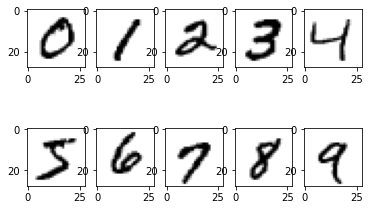

In [226]:
# your code
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

fig = plt.figure()

for i in range(10):
    im_idx = np.argwhere(y == str(i))[0]
    plottable_image = np.reshape(X[im_idx], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7)

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
The classification rule for Brenoulli NB: $ Pr(y|x) = Pr(y)Pr(x|y) = Pr(y) \Pi_{i=1}^{n}(p_{ji}^{x_{i}}(1-p_{ji}^{1-x_{i}})$ ==> The probability that a sample belongs to a class (the posterior) is equal to the probability of the class (the prior) times the likelihood of the sample given the class. The naive assumption of independence of the features allows us to treat the likelihood of the entire sample (image) as a product of the likelihood of its pixels. For a  multivariate Bernoulli event model, features are independent Booleans (binary variables), and the likeloihood of each pixel is given by $p_{ji}^{x_{i}}(1-p_{ji}^{1-x_{i}})$.

In some cases certain pixels may never be black (like the corner pixels), So we can add pseudo counts to all occurrences (Laplace Smoothing).

To estimate the parameters of the model based on the training data we use log maximum likelihood, i.e. find $argmax[log(Pr(y)) + \Sigma_{i=1}^{n}log(p_{ji}^{x_{i}}(1-p_{ji}^{1-x_{i}})]$. Using the log helps to deal with zero probabilities and treat the product as a sum of likelihoods. Finally we classify each sample to the class with highest likelihood. 
We need to estimate Pji and Pj given the training data.

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2

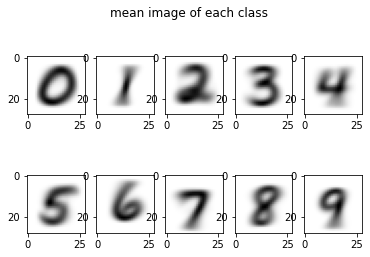

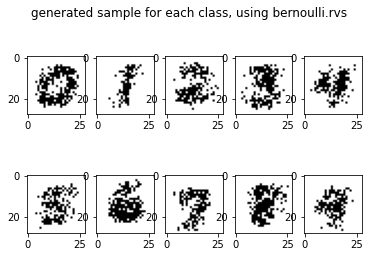

In [227]:
# code goes here
from sklearn.naive_bayes import BernoulliNB
from scipy.stats import bernoulli

# plot mean image of each class
clf = BernoulliNB(binarize=0)
clf.fit(X_train, y_train)
y_estimate = clf.predict(X_train)
fig = plt.figure()
plt.suptitle("mean image of each class")
for i in range(10):
    im_idx = np.argwhere(y_estimate == str(i))
    plottable_image = np.reshape(np.mean(X_train[im_idx],axis=0), (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

# generate a sample for each class    
probs = (np.exp(1) ** clf.feature_log_prob_) > 0.5 #* 255
probs = bernoulli.rvs(np.exp(1) ** clf.feature_log_prob_)
fig = plt.figure()
plt.suptitle("generated sample for each class, using bernoulli.rvs")
for i in range(10):
    plottable_image = np.reshape(probs[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')  

1. We can see that the generated samples for each class don't look like countinous lines that a human will write but as spread of dots by the shape of the the digit. This is because we sample each pixel independently.

Text(0.5, 1.0, 'Accuracy Score: 0.8283')

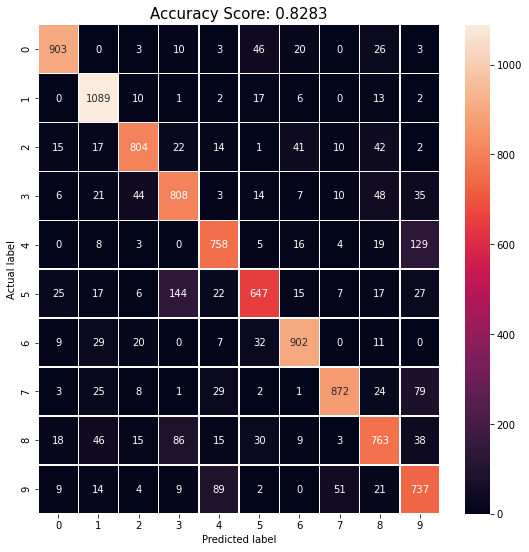

In [228]:
# Confusion matrix and accuracy score

from sklearn import metrics
import seaborn as sns

predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

2. The model accuracy of 0.83 is relatively not very good. This is probably due to assumption that we made in our model: we assumed that each and every pixel are independently generated, depending only on the label. This is not how humans write digits, and this wrong assumption led to this score.


3. **Think of a way you can find the optimal threshold of the binarization part:** 

We can optimize the homogenity of the digits margins as follows:
1. assign an initial threshold value
2. binarize the image
3. find for each black pixel (if the background is white) the horizontal and vertical number of contiguous (touching) black pixels (i.e. for each pixel look for continous pixels in both it's row and coloumn).
4. find the minimum of the horizontal and vertical traces
5. take the median of the minimum values of all pixels

We repeat these steps for different threshold values until we find the minimal median value, which represents the threshoild that creates the most homogenous borders.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

In [229]:
# implement Naive Bayes estimator

from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csr_matrix

class NaiveBayes(BaseEstimator, ClassifierMixin):
    
    # fit the trining data
    def fit(self, x, y):
        self.alpha = 1 # constant for laplace smoothing (for handeling zero probs when words are missing from document)
        count_sample = x.shape[0] # number of ducuments
        npx = csr_matrix.toarray(x) # compress the sparse matrices (resulting from count zero to most words in the document)
        separated = [[x_i for x_i, t in zip(npx, y) if t == c] for c in np.unique(y)]
        
        # prior log probability for each class
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        
        # count each word for each class and add smoothing
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        
        # calculate the log probability of each word
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        
        return self
    
    # outputs the log probability of each class
    def predict_log_proba(self, x):
        return [(self.feature_log_prob_ * x_i).sum(axis=1) + self.class_log_prior_ for x_i in x]
    
    # calls predict_log_proba and picks the maximum value
    def predict(self, x):
        npx = csr_matrix.toarray(x)
        return np.argmax(self.predict_log_proba(npx), axis=1)

In [230]:
# Our implementation accuracy over the test data

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# CountVectorizer to count words
count_vect = CountVectorizer(stop_words='english')

nb = NaiveBayes()

# chain the vectroizer and the model
pipe = make_pipeline(count_vect, nb)
pipe.fit(newsgroups_train.data, newsgroups_train.target)

# find accuracy over the test data
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
y_test = newsgroups_test.target
y_pred = pipe.predict(newsgroups_test.data)
report = metrics.classification_report(y_test, y_pred, target_names=newsgroups_test.target_names)

print("Our implementation accuracy over the test data:")
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Our implementation accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.30      0.41       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.40      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.53      0.72      0.61       392
   comp.sys.mac.hardware       0.74      0.56      0.64       385
          comp.windows.x       0.56      0.81      0.66       395
            misc.forsale       0.85      0.69      0.76       390
               rec.autos       0.82      0.70      0.76       396
         rec.motorcycles       0.91      0.62      0.73       398
      rec.sport.baseball       0.94      0.74      0.83       397
        rec.sport.hockey       0.58      0.91      0.71       399
               sci.crypt       0.54      0.79      0.64       396
         sci.electronics       0.71      0.49      0.58       393
                 sci.med   

In [231]:
# built in sklearn.naive_bayes.MultinomialNB accuracy

from sklearn.naive_bayes import MultinomialNB

sklearn_nb = MultinomialNB()
sklearn_pipe = make_pipeline(count_vect, sklearn_nb)
sklearn_pipe.fit(newsgroups_train.data, newsgroups_train.target)
sklearn_y_pred = sklearn_pipe.predict(newsgroups_test.data)
sklearn_report = metrics.classification_report(y_test, sklearn_y_pred, target_names=newsgroups_test.target_names)

print("sklearn.naive_bayes.MultinomialNB accuracy over the test data:")
print(sklearn_report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, sklearn_y_pred)))

sklearn.naive_bayes.MultinomialNB accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.30      0.41       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.40      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.53      0.72      0.61       392
   comp.sys.mac.hardware       0.74      0.56      0.64       385
          comp.windows.x       0.56      0.81      0.66       395
            misc.forsale       0.85      0.69      0.76       390
               rec.autos       0.82      0.70      0.76       396
         rec.motorcycles       0.91      0.62      0.73       398
      rec.sport.baseball       0.94      0.74      0.83       397
        rec.sport.hockey       0.58      0.91      0.71       399
               sci.crypt       0.54      0.79      0.64       396
         sci.electronics       0.71      0.49      0.58       393
            

In [232]:
# TfidfVectorizer preprocessing accuracy

from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(stop_words='english')
Tfidf_pipe = make_pipeline(Tfidf_vect, sklearn_nb)
Tfidf_pipe.fit(newsgroups_train.data, newsgroups_train.target)
Tfidf_y_pred = Tfidf_pipe.predict(newsgroups_test.data)
Tfidf_report = metrics.classification_report(y_test, Tfidf_y_pred, target_names=newsgroups_test.target_names)

print("TfidfVectorizer accuracy over the test data:")
print(Tfidf_report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, Tfidf_y_pred)))

TfidfVectorizer accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.76      0.18      0.28       319
           comp.graphics       0.67      0.69      0.68       389
 comp.os.ms-windows.misc       0.66      0.58      0.62       394
comp.sys.ibm.pc.hardware       0.60      0.74      0.66       392
   comp.sys.mac.hardware       0.77      0.67      0.71       385
          comp.windows.x       0.81      0.77      0.79       395
            misc.forsale       0.78      0.76      0.77       390
               rec.autos       0.84      0.73      0.78       396
         rec.motorcycles       0.87      0.74      0.80       398
      rec.sport.baseball       0.92      0.80      0.85       397
        rec.sport.hockey       0.57      0.93      0.71       399
               sci.crypt       0.59      0.79      0.67       396
         sci.electronics       0.72      0.52      0.60       393
                 sci.med      

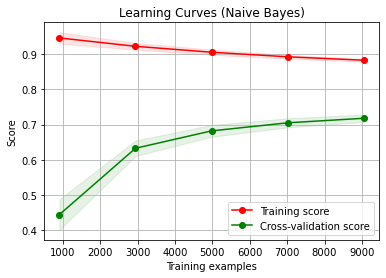

In [233]:
# create plot_learning_curve function and plot the learning curve

import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Naive Bayes)"
                        
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(Tfidf_pipe, title, newsgroups_train.data, newsgroups_train.target, cv=cv, n_jobs=4) 

plt.show()

Is the model in the bias or variance regime?

From the curve, we can see that as the size of the training set increases, the training score curve and the cross-validation score curve converge. The cross-validation accuracy increases as we add more training data. So adding training data is useful in this case.

At 9,000 samples the training score is quite high which indicates a low bias but the gap between the training and cross validation scores indicates a high variance. By increasing the training examples number we anticipate a decrease in the variance but also an increase of the bias.

In [234]:
# Optimize the model: run grid seaech to find best parameters values

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline_grid = Pipeline([
    ('tfidf', Tfidf_vect),
    ('clf', sklearn_nb),
])

parameters = {
    'tfidf__max_df': (0.1, 0.15, 0.20, 0.25, 0.5, 0.75), # "ignore terms that appear in more than *max_df* documents".
    'tfidf__max_features': np.arange(0,100000,5000)
}

grid_search_tune = GridSearchCV(pipeline_grid, parameters, n_jobs=-1, verbose=1)
grid_search_tune.fit(newsgroups_train.data, newsgroups_train.target)
best_est = grid_search_tune.best_estimator_.steps

print("Best parameters set:")
print (best_est)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.9min finished


Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.1, max_features=40000, stop_words='english')), ('clf', MultinomialNB())]


Optimized TfidfVectorizer accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.71      0.21      0.32       319
           comp.graphics       0.65      0.69      0.67       389
 comp.os.ms-windows.misc       0.66      0.61      0.63       394
comp.sys.ibm.pc.hardware       0.61      0.74      0.67       392
   comp.sys.mac.hardware       0.78      0.67      0.72       385
          comp.windows.x       0.83      0.76      0.79       395
            misc.forsale       0.76      0.76      0.76       390
               rec.autos       0.80      0.72      0.76       396
         rec.motorcycles       0.85      0.74      0.79       398
      rec.sport.baseball       0.91      0.80      0.85       397
        rec.sport.hockey       0.57      0.94      0.71       399
               sci.crypt       0.66      0.79      0.72       396
         sci.electronics       0.70      0.52      0.60       393
                 sci

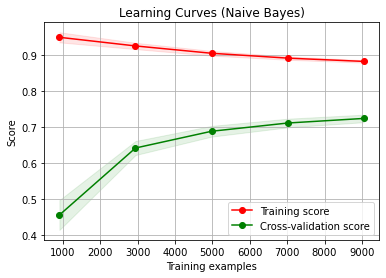

In [235]:
# creating a new model with the parameters found on the gridsearch CV

Tfidf_vect_optimized = TfidfVectorizer(max_df=0.1, max_features=40000, stop_words='english')
Tfidf_pipe_optimized = make_pipeline(Tfidf_vect_optimized, sklearn_nb)
Tfidf_pipe_optimized.fit(newsgroups_train.data, newsgroups_train.target)
Tfidf_y_pred_optimized = Tfidf_pipe_optimized.predict(newsgroups_test.data)
Tfidf_report_optimized = metrics.classification_report(y_test, Tfidf_y_pred_optimized,
                                                       target_names=newsgroups_test.target_names)

print("Optimized TfidfVectorizer accuracy over the test data:")
print(Tfidf_report_optimized)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, Tfidf_y_pred_optimized)))

plot_learning_curve(Tfidf_pipe_optimized, title, newsgroups_train.data, newsgroups_train.target, cv=cv, n_jobs=4) 
plt.show()

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [236]:
import string
def print_txt(txt, hot, cold):
    """
    print the text, coloring hot and cold words with colors
    """
    cold_color='\x1b[41;37m{}\x1b[0m'
    hot_color='\x1b[42;37m{}\x1b[0m'
    def color(token):
        lower = str(token).lower()
        lower = lower.replace('\t','').replace('\n','')
        lower = lower.translate(string.punctuation)
        if (lower in hot) and (lower in cold):
            return mid_color.format(token)
        elif lower in hot:
            return hot_color.format(token)
        elif lower in cold:
            return cold_color.format(token)
        else:
            return token
    colored_txt = " ".join([color(token) for token in txt.split(' ')])
    print(colored_txt)
print_txt('This word support the first class but this the other', ['word'],['other'])

This word support the first class but this the other


In [237]:
# returns vector of class probabilities given each feature
def calc_p_c_given_xi(model):
    log_prob_class = model.class_log_prior_
    prob_class = np.exp(log_prob_class)
    log_p_xi_y = model.feature_log_prob_
    p_xi_y = np.exp(log_p_xi_y)
    numerator = prob_class.reshape(-1,1)* p_xi_y
    p_c_xi = numerator/p_xi_y.sum(axis=0)
    return p_c_xi

In [240]:
# We show a few random documents with wrong prediction and color important words that support the correct class in green and
# important words that support the wrong class in red


p_c_xi = calc_p_c_given_xi(sklearn_nb) # class probabilities given each word
wrongs = np.where(np.equal(Tfidf_y_pred_optimized,y_test) == False) # indexes of wrong predictions

# get the dtidf vect vocabulary
x = Tfidf_vect_optimized.transform(newsgroups_test.data)
idx2word={v:k for k, v in Tfidf_vect_optimized.vocabulary_.items()}

# number of top words for each class
top_n = 90

print("Wrong classification examples:")

# for each chosen ducument we find the top words of the predicted class and correct class and color them in the document text.
# top words of the predicted wrong class are red and top words of the correct class are green
for i in np.random.choice(wrongs[0],3):
    pred_cat = Tfidf_y_pred_optimized[i]
    correct_cat = y_test[i]
    sorted_index_pred = np.argsort(p_c_xi[pred_cat])
    top_pred = sorted_index_pred[-top_n : ]
    top_pred_dict = { top_key: idx2word[top_key] for top_key in top_pred }
    sorted_index_correct = np.argsort(p_c_xi[correct_cat])
    top_correct = sorted_index_correct[-top_n : ]
    top_correct_dict = { top_key: idx2word[top_key] for top_key in top_correct }
    
    print('\nExample ',i)
    print('Predicted category: ',newsgroups_test.target_names[pred_cat])
    print('Correct category: ',newsgroups_test.target_names[correct_cat])
    print('\n')
    print_txt(newsgroups_test.data[i],list(top_correct_dict.values()) ,list(top_pred_dict.values()))
    print('\nEnd of Example ***************************************************************************')

Wrong classification examples:

Example  4724
Predicted category:  talk.politics.guns
Correct category:  talk.religion.misc



Didn't expect to find you in the Devil's role, Stephen, but these are
the times that try men's souls.
Nine months, as I understand it.  No doubt this accounts for a 
significant amount of the time as government efficiency in spending
our tax dollars would certainly seek its absolute minimum in such
an event.  But my gut instinct says there is more at hand.  It took
some careful preplanning to demonize D.K. to such an extent.  The
attack meshes well with more restrictive gun control legislation
that seems to be the agenda of the day.  It also fits a pattern of
increased government interference in personal religious beliefs.
[Randy Weaver is now on trial].

No quarrel here.  The BIG BANG theory is always apt at appropriation
time.  They just don't have to possess a single motive.
 

I certainly think publication of the warrant undermines the government's
case sin

How can you correct the analyzed error?

We can find the top contributing words for each category and check the ratio of false prediction for these words. Could be that some of them are not specific enough and should be removed from the model.